In [ ]:
!pip -q install tensorflow matplotlib scikit-learn gradio

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report
import itertools

AUTOTUNE = tf.data.AUTOTUNE

def plot_history(h):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(h.history['loss'], label='train loss')
    plt.plot(h.history['val_loss'], label='val loss')
    plt.legend(); plt.title('Loss')
    plt.subplot(1,2,2)
    plt.plot(h.history['accuracy'], label='train acc')
    plt.plot(h.history['val_accuracy'], label='val acc')
    plt.legend(); plt.title('Accuracy')
    plt.show()

def plot_confusion(cm, classes):
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix'); plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2. if cm.max()>0 else 0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label'); plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [ ]:
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = y_train.flatten()
y_test = y_test.flatten()

class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.1, stratify=y_train, random_state=42
)

IMG_SIZE = 160
BATCH = 16
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(preprocess, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.shuffle(2000).batch(BATCH).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).map(preprocess, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(BATCH).prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).map(preprocess, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH).prefetch(AUTOTUNE)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


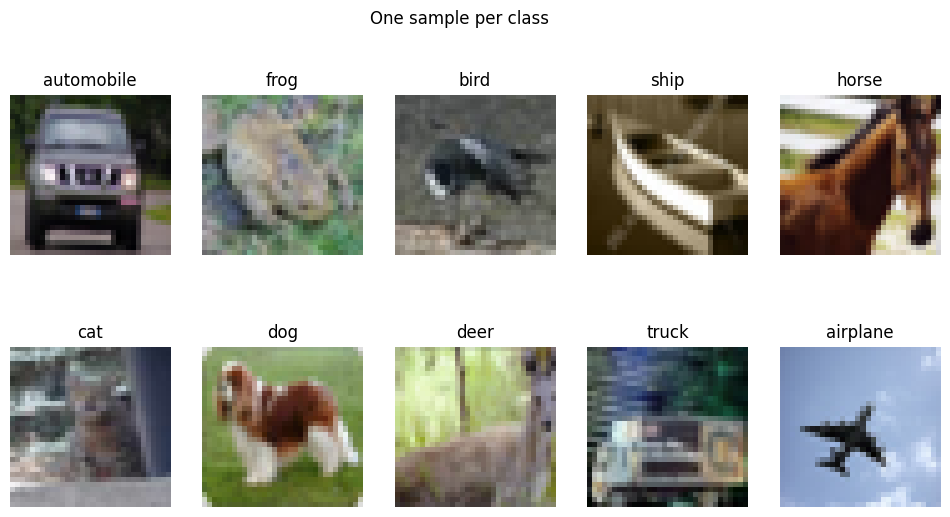

In [ ]:
def show_one_sample_per_class(x_array, y_array, class_names, max_per_row=5):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,6))
    shown = set()
    i = 0
    for img, lbl in zip(x_array, y_array):
        if lbl not in shown:
            shown.add(lbl)
            plt.subplot(2, max_per_row, i+1)
            plt.imshow(img)
            plt.title(class_names[lbl])
            plt.axis('off')
            i += 1
        if i >= 10: break
    plt.suptitle("One sample per class")
    plt.show()

show_one_sample_per_class(x_train, y_train, class_names)

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.06),
    layers.RandomZoom(0.06),
], name="data_augmentation")

In [ ]:
base_model = tf.keras.applications.MobileNetV2(include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3), weights='imagenet')
base_model.trainable = False

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model = keras.Model(inputs, outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/6
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.1055 - loss: 2.4009

2813/2813 ━━━━━━━━━━━━━━━━━━━━ 1217s 427ms/step - accuracy: 0.1055 - loss: 2.4009 - val_accuracy: 0.1346 - val_loss: 2.2930
Epoch 2/6
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.1120 - loss: 2.3019

2813/2813 ━━━━━━━━━━━━━━━━━━━━ 1174s 410ms/step - accuracy: 0.1120 - loss: 2.3019 - val_accuracy: 0.1450 - val_loss: 2.2821
Epoch 3/6
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.1298 - loss: 2.2798

2813/2813 ━━━━━━━━━━━━━━━━━━━━ 1231s 435ms/step - accuracy: 0.1298 - loss: 2.2798 - val_accuracy: 0.1494 - val_loss: 2.2472
Epoch 4/6
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.1384 - loss: 2.2570

2813/2813 ━━━━━━━━━━━━━━━━━━━━ 1277s 433ms/step - accuracy: 0.1384 - loss: 2.2570 - val_accuracy: 0.1550 - val_loss: 2.2328
Epoch 5/6
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.1388 - loss: 2.2466

2813/2813 ━━━━━━━━━━━━━━━━━━━━ 1214s 431ms/step - accuracy: 0.1388 - loss: 2.2466 - val_accuracy: 0.1584 - val_loss: 2.2206
Epoch 6/6
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.1446 - loss: 2.2330

2813/2813 ━━━━━━━━━━━━━━━━━━━━ 1186s 421ms/step - accuracy: 0.1446 - loss: 2.2330 - val_accuracy: 0.1622 - val_loss: 2.2126


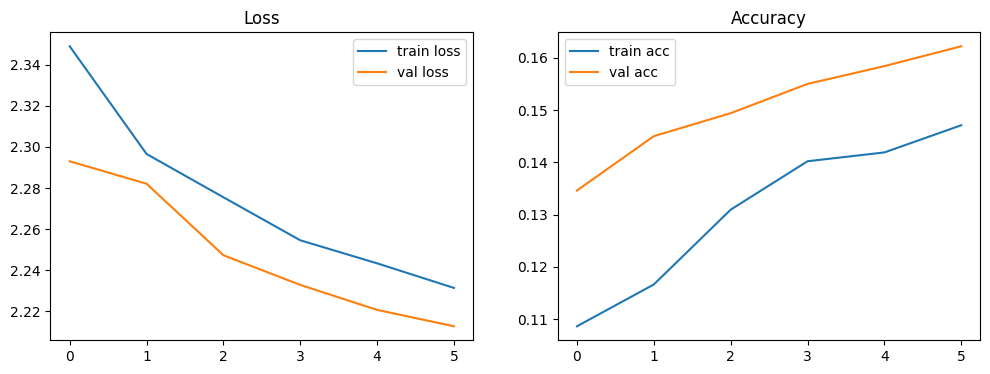

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint('best_mobilenet.h5', save_best_only=True, monitor='val_accuracy'),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
]

EPOCHS_TOP = 6
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_TOP, callbacks=callbacks)
plot_history(history)

Epoch 1/6
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 1473s 517ms/step - accuracy: 0.4229 - loss: 1.5957 - val_accuracy: 0.3386 - val_loss: 1.9185
Epoch 2/6
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.4337 - loss: 1.5704

2813/2813 ━━━━━━━━━━━━━━━━━━━━ 1467s 521ms/step - accuracy: 0.4337 - loss: 1.5704 - val_accuracy: 0.4394 - val_loss: 1.5503
Epoch 3/6
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.4450 - loss: 1.5396

2813/2813 ━━━━━━━━━━━━━━━━━━━━ 1452s 516ms/step - accuracy: 0.4450 - loss: 1.5396 - val_accuracy: 0.4680 - val_loss: 1.4765
Epoch 4/6
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 1517s 535ms/step - accuracy: 0.4561 - loss: 1.5185 - val_accuracy: 0.4416 - val_loss: 1.5360
Epoch 5/6
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.4588 - loss: 1.5006

2813/2813 ━━━━━━━━━━━━━━━━━━━━ 1513s 537ms/step - accuracy: 0.4588 - loss: 1.5006 - val_accuracy: 0.4864 - val_loss: 1.4340
Epoch 6/6
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 1464s 520ms/step - accuracy: 0.4673 - loss: 1.4825 - val_accuracy: 0.3458 - val_loss: 2.0245


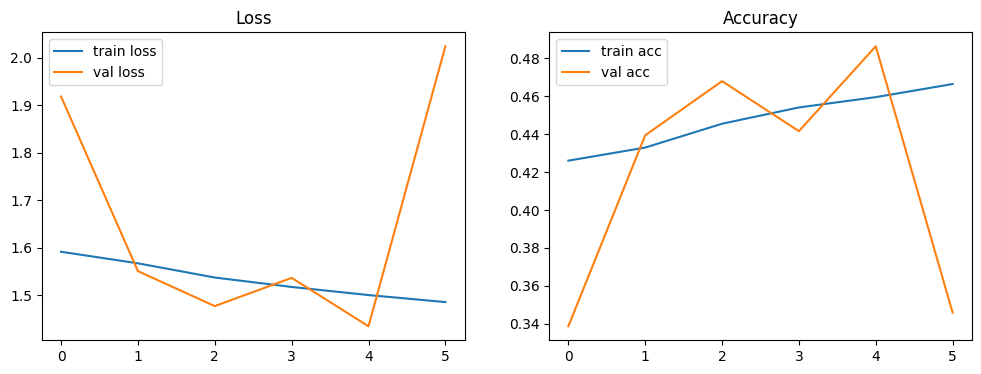

In [ ]:
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 30
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

EPOCHS_FINE = 6
history_f = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_FINE, callbacks=callbacks)
plot_history(history_f)

import os
if os.path.exists('best_mobilenet.h5'):
    model.load_weights('best_mobilenet.h5')

625/625 ━━━━━━━━━━━━━━━━━━━━ 192s 307ms/step - accuracy: 0.4928 - loss: 1.4133
Test accuracy: 0.48660001158714294
625/625 ━━━━━━━━━━━━━━━━━━━━ 174s 279ms/step


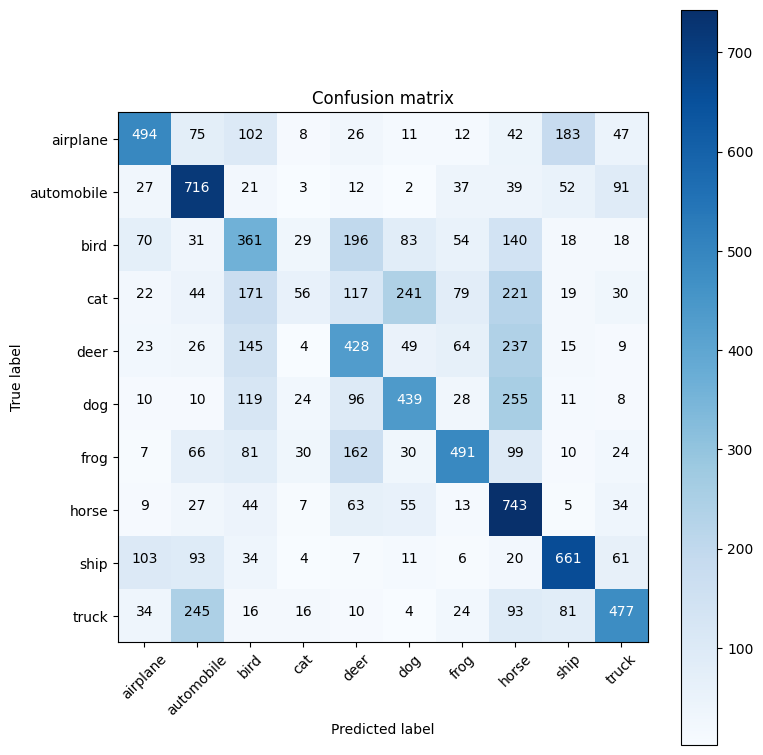

              precision    recall  f1-score   support

    airplane       0.62      0.49      0.55      1000
  automobile       0.54      0.72      0.61      1000
        bird       0.33      0.36      0.34      1000
         cat       0.31      0.06      0.09      1000
        deer       0.38      0.43      0.40      1000
         dog       0.47      0.44      0.46      1000
        frog       0.61      0.49      0.54      1000
       horse       0.39      0.74      0.51      1000
        ship       0.63      0.66      0.64      1000
       truck       0.60      0.48      0.53      1000

    accuracy                           0.49     10000
   macro avg       0.49      0.49      0.47     10000
weighted avg       0.49      0.49      0.47     10000



In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy:", test_acc)

y_true = np.concatenate([y.numpy() for x,y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)
plot_confusion(cm, class_names)
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step


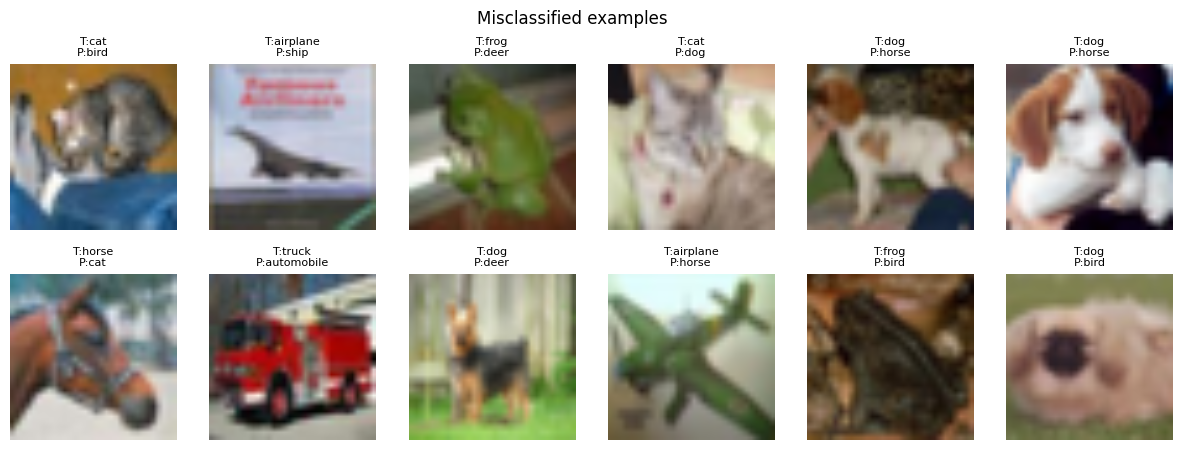

In [ ]:
def show_misclassified(model, dataset, class_names, max_images=12):
    import matplotlib.pyplot as plt
    images = []
    y_t = []
    y_p = []
    for img_batch, lbl_batch in dataset:
        preds = model.predict(img_batch)
        for img, true, predp in zip(img_batch, lbl_batch, np.argmax(preds, axis=1)):
            if true.numpy() != predp:
                images.append(img.numpy())
                y_t.append(true.numpy())
                y_p.append(predp)
            if len(images) >= max_images:
                break
        if len(images) >= max_images:
            break

    cols = min(6, max_images)
    rows = (len(images)+cols-1)//cols
    plt.figure(figsize=(cols*2.5, rows*2.5))
    for i, img in enumerate(images):
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.title(f"T:{class_names[y_t[i]]}\nP:{class_names[y_p[i]]}", fontsize=8)
        plt.axis("off")
    plt.suptitle("Misclassified examples")
    plt.show()

show_misclassified(model, test_ds, class_names)

In [ ]:
model.save('cifar10_mobilenet_model.keras')
print("Saved model to cifar10_mobilenet_model.keras/")

Saved model to cifar10_mobilenet_model.keras/


In [24]:
import gradio as gr

def predict_gradio(img):
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)).numpy() / 255.0
    preds = model.predict(np.expand_dims(img, 0))[0]
    top3 = preds.argsort()[-3:][::-1]
    return {class_names[i]: float(preds[i]) for i in top3}

demo = gr.Interface(
    fn=predict_gradio,
    inputs=gr.Image(type='numpy', label='Webcam / Upload'),
    outputs=gr.Label(num_top_classes=3),
    title="CIFAR-10 AI Agent",
    description="Predicts one of the 10 CIFAR-10 classes from webcam or uploaded image."
)
demo.launch(share=False)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>